In [1]:
import intake
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
# Install pyclimdex

# !pip install pyclimdex

  Using cached pyclimdex-0.0.1-py2.py3-none-any.whl.metadata (429 bytes)
Using cached pyclimdex-0.0.1-py2.py3-none-any.whl (5.5 kB)


import climdex.precipitation as pdex # install pyclimdex in previous cell if not installed
import climdex.temperature as tdex 

# Loading dask cluster

In [20]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33461 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33461/status,
Dashboard: http://127.0.0.1:33461/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46085,Workers: 4
Dashboard: http://127.0.0.1:33461/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:45399,Total threads: 1
Dashboard: http://127.0.0.1:36193/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:46367,


# climdex Indices

In [3]:
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)

catalog = catalog.search(variable=['TREFHTMN', 'TREFHTMX'], frequency='daily')
dsets = catalog.to_dataset_dict(storage_options={"anon":True})
dsets.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 10.58 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 10.58 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


dict_keys(['atm.ssp370.daily.cmip6', 'atm.ssp370.daily.smbb', 'atm.historical.daily.smbb', 'atm.historical.daily.cmip6'])

In [4]:
hist_cmip6 = dsets['atm.historical.daily.cmip6']
hist_cmip6

<xarray.Dataset> Size: 1TB
Dimensions:    (member_id: 50, time: 60225, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, nbnd) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHTMN   (member_id, time, lat, lon) float32 666GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
    TREFHTMX   (member_id, time, lat, lon) float32 666GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                       CF-1.0
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  day_1
    topography_file:                   /mnt/lustre/share/CESM/cesm_input/atm/...
    ...                                ...
    intake_esm_attrs:spatial_domain:   global
    intake_esm_attrs:units:            K
    intake_esm_attrs:start_time:       1850-01-01 12:00:00
    intake_esm_attrs:end_time:         2014-12-31 12:00:00
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.historical.daily.cmip6

In [63]:
hist_cmip6['TREFHTMX']

<xarray.DataArray 'TREFHTMX' (member_id: 50, time: 60225, lat: 192, lon: 288)> Size: 666GB
dask.array<open_dataset-TREFHTMX, shape=(50, 60225, 192, 288), dtype=float32, chunksize=(1, 730, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

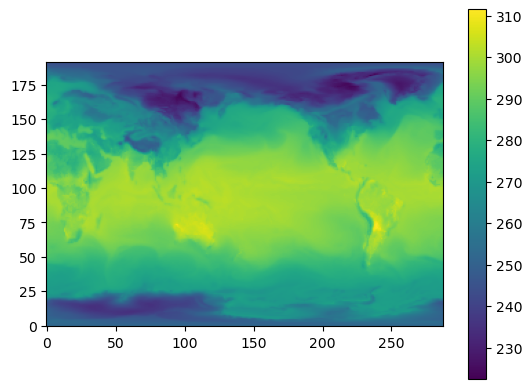

In [8]:
# plots max tref for first member of first time step
plt.imshow(hist_cmip6['TREFHTMX'].data[0,0], origin='lower')
plt.colorbar()

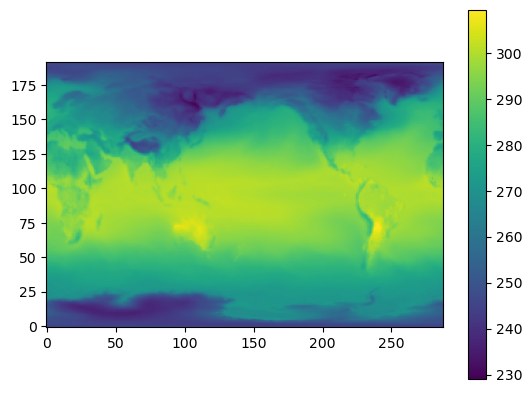

In [10]:
# plots mean trefhtmx across all 50 members for first time step
plt.imshow(hist_cmip6['TREFHTMX'].data[:,0].mean(axis=0), origin='lower')
plt.colorbar()

In [11]:
start_year = 1980
end_year = 2010

# The dataset starts from 1850. So, starting index for 1980 is

start_index = (start_year - 1850)*365
end_index = (end_year - 1850)*365 + 364

start_index, end_index

(47450, 58764)

In [37]:
tindices = tdex.indices(time_dim='time', convert_units_fn= lambda x: x-273.15) # the parameter convert_units_fn should hopefully convert temperature from Kelvin to Celsius
# convert_units_fn does not work for monthly indices
m_txx = tindices.monthly_txx(hist_cmip6['TREFHTMX'][0, start_index:end_index]) # calculate monthly txx from first member of data

<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


In [38]:
m_txx

<xarray.DataArray 'TREFHTMX' (time: 372, lat: 192, lon: 288)> Size: 82MB
dask.array<transpose, shape=(372, 192, 288), dtype=float32, chunksize=(24, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r10i1181p1f1'
  * time       (time) object 3kB 1980-01-31 00:00:00 ... 2010-12-31 00:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

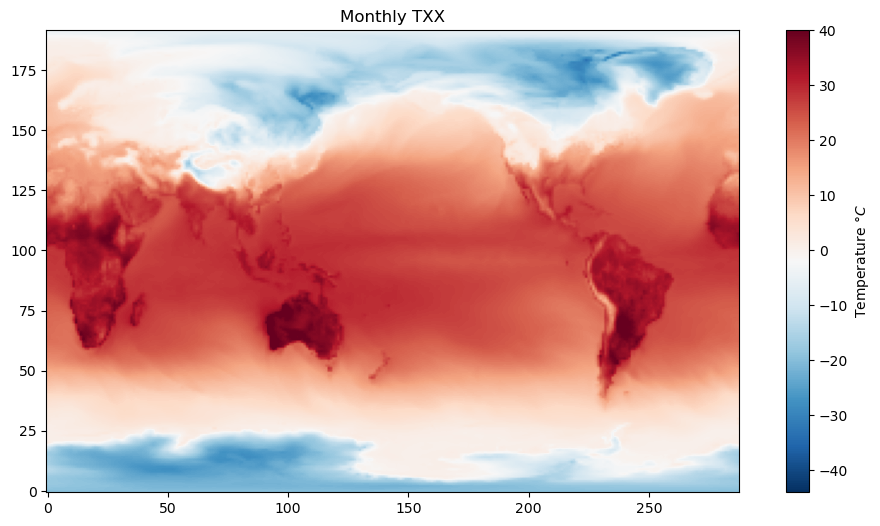

In [57]:
m = 2 # figure size multiplier
f, ax = plt.subplots(1, figsize=(6*m, 3*m))

norm=plt.Normalize(40, -40)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
ax.imshow(m_txx[0]-273.15, cmap='RdBu_r', norm=norm, origin='lower')
ax.set_aspect(1)
plt.title('Monthly TXX')
plt.colorbar(sm, ax=ax, label=r'Temperature ${\degree C}$')

In [39]:
372/12

31.0

# HEAT WAVES

In [5]:
# Define the minimum duration for a heatwave
min_duration = 5  # Minimum number of consecutive days
delta_temp = 5  # Temperature threshold above the average maximum


# Function to calculate the climatological average maximum temperature for each day of the year
def calculate_climatological_average(temp):
    return temp.groupby("time.dayofyear").mean("time")
    
# Function to identify heatwaves
def identify_heatwaves(temp, avg_max_temp, delta, min_duration):

    nlat = temp.shape[1]
    nlon = temp.shape[2]
    
    # avg_max_temp should be numpy array
    threshold = avg_max_temp + delta
    
    # Create empty heatwave_counts array
    print(len(np.unique(temp['time.year'])))
    heatwave_counts = np.zeros((len(np.unique(temp["time.year"])), temp.shape[1], temp.shape[2]))
    print('Created empty array of shape', heatwave_counts.shape)
    
    for i, year in enumerate(np.unique(temp["time.year"])):
        year_data = temp.sel(time=str(year)) # selects one year data
        above_threshold = year_data > threshold # mask for temp greater than temp threshold
        above_threshold.load()
        
        for ny in range(nlat):
            print(ny)
            for nx in range(nlon):
                # print(nx)
                consecutive_days = 0
                for day in range(year_data.shape[0]):
                    # print(day)
                    if above_threshold[day,ny,nx]:
                        consecutive_days += 1
                        if consecutive_days == min_duration:
                            heatwave_counts[i, ny, nx] += 1
                    else:
                        consecutive_days = 0
    return heatwave_counts

In [6]:
start_year = 1980
end_year = 2010

# The dataset starts from 1850. So, starting index for 1980 is

start_index = (start_year - 1850)*365
end_index = (end_year - 1850)*365 + 364

start_index, end_index

(47450, 58764)

In [7]:
# Calculates daily avg maximum temperature from 1980-2010
avg_max_temp_daily = calculate_climatological_average(hist_cmip6['TREFHTMX'][0, start_index:end_index])
avg_max_temp_daily

<xarray.DataArray 'TREFHTMX' (dayofyear: 365, lat: 192, lon: 288)> Size: 81MB
dask.array<transpose, shape=(365, 192, 288), dtype=float32, chunksize=(365, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  <U12 48B 'r10i1181p1f1'
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [8]:
tmax_1980 = hist_cmip6['TREFHTMX'][0, start_index:start_index+365]


In [9]:
tmax_1980_2010 = hist_cmip6['TREFHTMX'][0, start_index:end_index+1]


In [15]:
tmax_1980['time'].data[0]

cftime.DatetimeNoLeap(1980, 1, 1, 12, 0, 0, 0, has_year_zero=True)

In [24]:
min_lon = 170
min_lat = 120 
max_lon = 250
max_lat = 150 


cropped_tmax_1980 = tmax_1980.isel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
cropped_avg_tmax = avg_max_temp_daily.isel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

In [21]:
heat_waves=identify_heatwaves(cropped_tmax_1980, cropped_avg_tmax.data, delta_temp, min_duration)

1
Created empty array of shape (1, 50, 80)


2024-06-14 17:24:27,945 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 3.13 GiB -- Worker memory limit: 3.71 GiB
2024-06-14 17:24:27,946 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.13 GiB -- Worker memory limit: 3.71 GiB
2024-06-14 17:24:28,027 - distributed.worker.memory - WARNING - Worker is at 68% memory usage. Resuming worker. Process memory: 2.54 GiB -- Worker memory limit: 3.71 GiB
2024-06-14 17:24:29,870 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 3.09 GiB -- Worker memory limit: 3.71 GiB
2024-06-14 17:24:30,026 - distributed.worker.memory - WARNING - Worker is at 67% memory usage. Resuming worker. Process memory: 2.49 GiB 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Text(0.5, 1.0, 'Number of heatwaves in 1980')

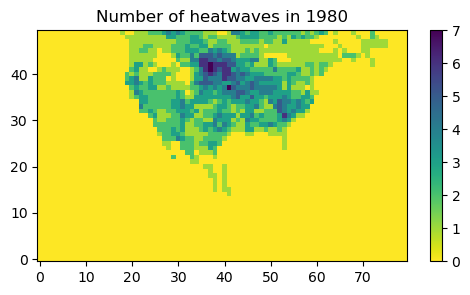

In [29]:
f, ax = plt.subplots(1, figsize=(6,3))
im=ax.imshow(heat_waves[0], origin='lower', cmap='viridis_r')
ax.set_aspect(1)
plt.colorbar(im, ax=ax)
plt.title('Number of heatwaves in 1980')

In [19]:
client.shutdown()